# 1. data preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os

In [2]:
# there are some ", and \n" inside some examples so we need to handle that when reading csv
import csv

input_file = '../dataset/train.csv'
output_file = '../dataset/train_fixed.csv'

with open(input_file, 'r', encoding='utf-8', newline='') as infile, \
     open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    
    reader = csv.reader(infile)
    # this line means if face some special charater mentioned above, it will quote them as a whole part
    writer = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL)
    
    headers = next(reader)
    writer.writerow(headers)

    for row in reader:
        if len(row) >= 3:
            img_id, labels = row[0], row[1]
            caption_parts = row[2:]

            caption_parts = [part.replace('\n', '').replace('\r', '').strip()
                             for part in caption_parts if part.strip() != '']

            caption = ', '.join(caption_parts).rstrip(',')

            writer.writerow([img_id, labels, caption])
        else:
            print(f"still have some issues inside rows (test)：{row}")
            
print(f"finished! new document file path:{output_file}")

finished! new document file path:../dataset/train_fixed.csv


In [3]:
# there some ", and \n" inside some examples so we need to handle that when reading csv
import csv

input_file = '../dataset/test.csv'
output_file = '../dataset/test_fixed.csv'

with open(input_file, 'r', encoding='utf-8', newline='') as infile, \
     open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    
    reader = csv.reader(infile)
    # this line means if face some special charater mentioned above, it will quote them as a whole part
    writer = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL)
    
    headers = next(reader)
    writer.writerow(headers)

    for row in reader:
        if len(row) >= 2:
            img_id = row[0]
            caption_parts = row[1:]

            caption_parts = [part.replace('\n', '').replace('\r', '').strip()
                             for part in caption_parts if part.strip() != '']

            caption = ', '.join(caption_parts).rstrip(',')

            writer.writerow([img_id, caption])
        else:
            print(f"still have some issues inside rows (test)：{row}")
            
print(f"finished! new document file path:{output_file}")

finished! new document file path:../dataset/test_fixed.csv


In [4]:
train_df = pd.read_csv('../dataset/train_fixed.csv')
test_df = pd.read_csv('../dataset/test_fixed.csv')

In [5]:
# some caption ends with "," so wrongly generate a new column
train_df.drop(columns=['Unnamed: 3'], inplace=True)
train_df.to_csv('../dataset/train_fixed.csv', index=False, encoding='utf-8')

In [7]:
train_df.head(5)

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


# 2. handle imgs and labels

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

csv_file = '../dataset/train_fixed.csv'
df = pd.read_csv(csv_file)

# split the  datasets 80%train 10%val 10%test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# save the new datasets
train_df.to_csv('../dataset/train_split.csv', index=False)
val_df.to_csv('../dataset/val_split.csv', index=False)
test_df.to_csv('../dataset/test_split.csv', index=False)

print(f"train_split: {len(train_df)}")
print(f"validation_split: {len(val_df)}")
print(f"test_split: {len(test_df)}")

训练集大小: 24000
验证集大小: 3000
测试集大小: 3000


In [7]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
from torchvision.transforms import Compose, ToTensor

class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.num_classes = 18

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['ImageID']
        img_path = os.path.join(self.img_dir, img_id)
    
        # load padding imgs
        image = Image.open(img_path).convert('RGB')
    
        if self.transform:
            image = self.transform(image)
    
        # one-hot, totally 18 classes, checked with raw datasets, there is no class 12 at all
        label_vec = torch.zeros(self.num_classes, dtype=torch.float32)
        labels_str = str(row['Labels']).split()
        for label in labels_str:
            label_idx = int(label) - 1
            if label_idx < 11:          # 1-11
                label_vec[label_idx] = 1.0
            elif label_idx > 11:        # 13-19
                label_vec[label_idx - 1] = 1.0
        return image, label_vec, img_id


In [8]:
from torch.utils.data import DataLoader
import pandas as pd
from torchvision.transforms import Compose, ToTensor

processed_img_dir = '../dataset/processed_images'

train_df = pd.read_csv('../dataset/train_split.csv')
val_df = pd.read_csv('../dataset/val_split.csv')
test_df = pd.read_csv('../dataset/test_split.csv')

# define transform
# ToTensor() converts the PIL image into Tensor data, automatically changing the pixel value of the image 
# from [0,255] to [0,1], and adjusting the dimension from (H, W, C) to (C, H, W).
transform = Compose([ToTensor()])

train_dataset = ImageDataset(train_df, processed_img_dir, transform)
val_dataset = ImageDataset(val_df, processed_img_dir, transform)
test_dataset = ImageDataset(test_df, processed_img_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

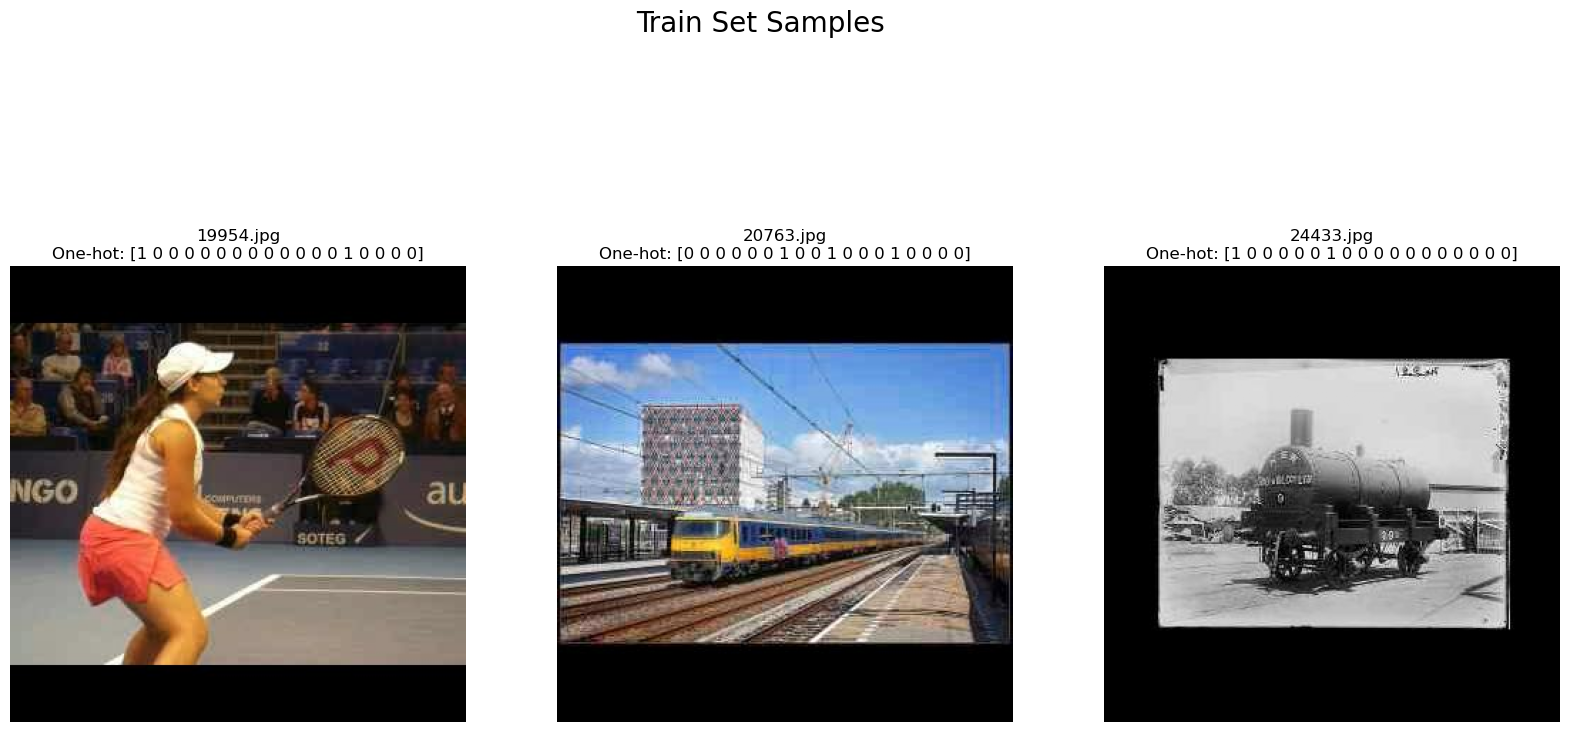

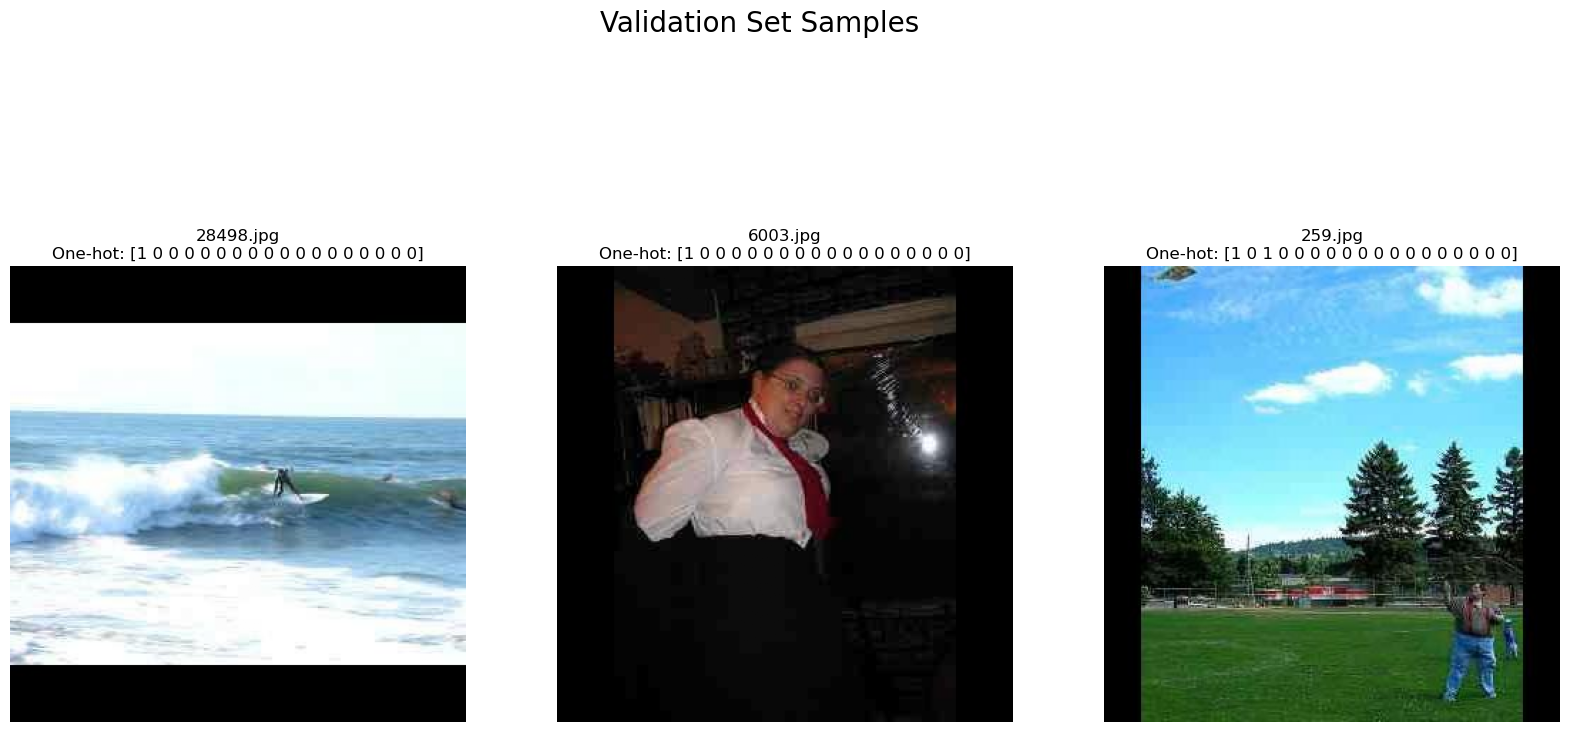

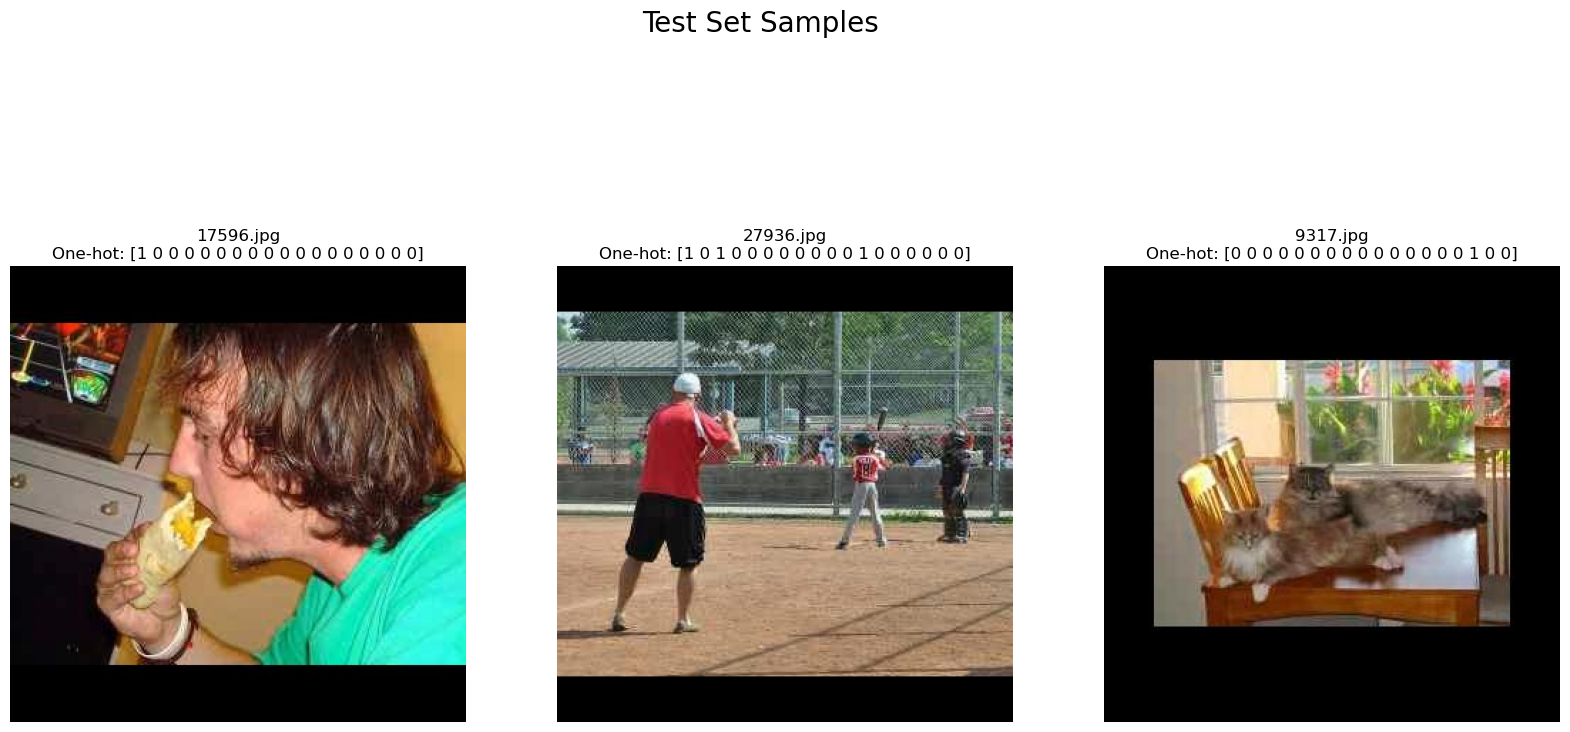

In [11]:
import matplotlib.pyplot as plt

def show_samples(loader, title):
    images, labels, img_ids = next(iter(loader))

    plt.figure(figsize=(20, 10))
    for idx in range(min(3, len(images))):
        image = images[idx].permute(1, 2, 0).numpy()
        label = labels[idx].numpy().astype(int)
        img_id = img_ids[idx]

        plt.subplot(1, 3, idx + 1)
        plt.imshow(image)
        plt.title(f"{img_id}\nOne-hot: {label}")
        plt.axis('off')

    plt.suptitle(title, fontsize=20)
    plt.show()

show_samples(train_loader, "Train Set Samples")
show_samples(val_loader, "Validation Set Samples")
show_samples(test_loader, "Test Set Samples")


In [ ]:
train_df.head()

In [13]:
train_df[train_df['ImageID'] == '19954.jpg']
# note that there are slightly different in the position, because there isn't class 12, so the original index of class 12 becomes class 13

,ImageID,Labels,Caption
12620,19954.jpg,1 15,A woman is on an indoor court playing tennis.


# 3. CNN

In [14]:
import torch
import torch.nn as nn

# Basic convolutional block: Conv2d -> BatchNorm -> ReLU
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, 
                               padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Inception-ResNet-A module (37x37 grid in original Inception-ResNet-v1)
class InceptionResNetA(nn.Module):
    def __init__(self, in_channels):
        super(InceptionResNetA, self).__init__()
        # Branch 0: 1x1 conv
        self.branch0 = BasicConv2d(in_channels, 32, kernel_size=1)
        # Branch 1: 1x1 conv -> 3x3 conv
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channels, 32, kernel_size=1),
            BasicConv2d(32, 32, kernel_size=3, padding=1)
        )
        # Branch 2: 1x1 conv -> 3x3 conv -> 3x3 conv
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, 32, kernel_size=1),
            BasicConv2d(32, 32, kernel_size=3, padding=1),
            BasicConv2d(32, 32, kernel_size=3, padding=1)
        )
        # Concatenate branches outputs (channels: 32+32+32 = 96), then linear 1x1 conv to match in_channels
        self.concat_conv = nn.Conv2d(96, in_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        out0 = self.branch0(x)
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        # Concatenate outputs of all branches along channel dimension
        out = torch.cat([out0, out1, out2], dim=1)
        # Linear combination to reduce channels back to in_channels
        out = self.concat_conv(out)
        # Residual add & ReLU
        out = self.relu(out + x)
        return out

# Inception-ResNet-B module (18x18 grid in original network)
class InceptionResNetB(nn.Module):
    def __init__(self, in_channels):
        super(InceptionResNetB, self).__init__()
        # Branch 0: 1x1 conv
        self.branch0 = BasicConv2d(in_channels, 128, kernel_size=1)
        # Branch 1: 1x1 conv -> 1x7 conv -> 7x1 conv
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channels, 128, kernel_size=1),
            BasicConv2d(128, 128, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(128, 128, kernel_size=(7, 1), padding=(3, 0))
        )
        # Concatenate (128+128=256 channels), then linear conv back to in_channels
        self.concat_conv = nn.Conv2d(256, in_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        out0 = self.branch0(x)
        out1 = self.branch1(x)
        out = torch.cat([out0, out1], dim=1)
        out = self.concat_conv(out)
        out = self.relu(out + x)  # residual connection
        return out

# Inception-ResNet-C module (8x8 grid in original network)
class InceptionResNetC(nn.Module):
    def __init__(self, in_channels):
        super(InceptionResNetC, self).__init__()
        # Branch 0: 1x1 conv
        self.branch0 = BasicConv2d(in_channels, 192, kernel_size=1)
        # Branch 1: 1x1 conv -> 1x3 conv -> 3x1 conv
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=1),
            BasicConv2d(192, 192, kernel_size=(1, 3), padding=(0, 1)),
            BasicConv2d(192, 192, kernel_size=(3, 1), padding=(1, 0))
        )
        # Concatenate (192+192=384), linear conv to in_channels
        self.concat_conv = nn.Conv2d(384, in_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        out0 = self.branch0(x)
        out1 = self.branch1(x)
        out = torch.cat([out0, out1], dim=1)
        out = self.concat_conv(out)
        out = self.relu(out + x)  # residual add
        return out

# Reduction-A block: reduces spatial size (37x37 -> 18x18) and increases channels
class ReductionA(nn.Module):
    def __init__(self, in_channels):
        super(ReductionA, self).__init__()
        # Branch 0: 3x3 conv stride 2
        self.branch0 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)
        # Branch 1: 1x1 conv -> 3x3 conv -> 3x3 conv (stride 2)
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=1),
            BasicConv2d(192, 192, kernel_size=3, padding=1),
            BasicConv2d(192, 256, kernel_size=3, stride=2)
        )
        # Branch 2: 3x3 max pool stride 2
        self.branch2 = nn.MaxPool2d(kernel_size=3, stride=2)
    def forward(self, x):
        out0 = self.branch0(x)
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        # Concatenate along channels (output channels: 384+256+in_channels)
        out = torch.cat([out0, out1, out2], dim=1)
        return out

# Reduction-B block: reduces spatial size (17x17 -> 8x8), increases channels
class ReductionB(nn.Module):
    def __init__(self, in_channels):
        super(ReductionB, self).__init__()
        # Branch 0: 1x1 conv -> 3x3 conv (stride 2)
        self.branch0 = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )
        # Branch 1: 1x1 conv -> 3x3 conv (stride 2)
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )
        # Branch 2: 1x1 conv -> 3x3 conv -> 3x3 conv (stride 2)
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1),
            BasicConv2d(256, 256, kernel_size=3, padding=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )
        # Branch 3: 3x3 max pool stride 2
        self.branch3 = nn.MaxPool2d(kernel_size=3, stride=2)
    def forward(self, x):
        out0 = self.branch0(x)
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        # Concatenate outputs of all branches
        out = torch.cat([out0, out1, out2, out3], dim=1)
        return out

# Complete Inception-ResNet-v1 model for multi-label classification
class InceptionResNetV1_MultiLabel(nn.Module):
    def __init__(self, num_classes=18, dropout_prob=0.5):
        super(InceptionResNetV1_MultiLabel, self).__init__()
        # Stem convolutional layers (output feature map size: 79x79 with 256 channels)
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)      # 320 -> 159
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)     # 159 -> 157 (padding later keeps size)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 157 -> 157
        self.maxpool_3a = nn.MaxPool2d(kernel_size=3, stride=2)           # 157 -> 78
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)     # 78 -> 78
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)    # 78 -> 76
        self.conv2d_4b = BasicConv2d(192, 256, kernel_size=3, stride=2)   # 76 -> 38
        # Inception-ResNet-A modules (×5)
        self.irA1 = InceptionResNetA(256)
        self.irA2 = InceptionResNetA(256)
        self.irA3 = InceptionResNetA(256)
        self.irA4 = InceptionResNetA(256)
        self.irA5 = InceptionResNetA(256)
        # Reduction-A to go from 37×37 -> 18×18 (channels: 256 -> 896)
        self.reduction_A = ReductionA(256)
        # Inception-ResNet-B modules (×10)
        self.irB1 = InceptionResNetB(896)
        self.irB2 = InceptionResNetB(896)
        self.irB3 = InceptionResNetB(896)
        self.irB4 = InceptionResNetB(896)
        self.irB5 = InceptionResNetB(896)
        self.irB6 = InceptionResNetB(896)
        self.irB7 = InceptionResNetB(896)
        self.irB8 = InceptionResNetB(896)
        self.irB9 = InceptionResNetB(896)
        self.irB10 = InceptionResNetB(896)
        # Reduction-B to go from 18×18 -> 8×8 (channels: 896 -> 1792)
        self.reduction_B = ReductionB(896)
        # Inception-ResNet-C modules (×5)
        self.irC1 = InceptionResNetC(1792)
        self.irC2 = InceptionResNetC(1792)
        self.irC3 = InceptionResNetC(1792)
        self.irC4 = InceptionResNetC(1792)
        self.irC5 = InceptionResNetC(1792)
        # Output head: global average pool -> dropout -> linear -> sigmoid
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc = nn.Linear(1792, num_classes)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        # Stem
        x = self.conv2d_1a(x)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.conv2d_4b(x)
        # Inception-ResNet-A (3 blocks)
        x = self.irA1(x)
        x = self.irA2(x)
        x = self.irA3(x)
        x = self.irA4(x)
        x = self.irA5(x)
        # Reduction-A
        x = self.reduction_A(x)
        # Inception-ResNet-B (6 blocks)
        x = self.irB1(x)
        x = self.irB2(x)
        x = self.irB3(x)
        x = self.irB4(x)
        x = self.irB5(x)
        x = self.irB6(x)
        x = self.irB7(x)
        x = self.irB8(x)
        x = self.irB9(x)
        x = self.irB10(x)
        # Reduction-B
        x = self.reduction_B(x)
        # Inception-ResNet-C (3 blocks)
        x = self.irC1(x)
        x = self.irC2(x)
        x = self.irC3(x)
        x = self.irC4(x)
        x = self.irC5(x)
        # Global average pooling, dropout, and fully-connected
        x = self.avg_pool(x)               # shape: (batch, 1792, 1, 1)
        x = x.view(x.size(0), -1)          # flatten to (batch, 1792)
        x = self.dropout(x)
        logits = self.fc(x)                # linear output (batch, 18)
        probs = self.sigmoid(logits)       # apply sigmoid to get probabilities in [0,1]
        return probs

In [18]:
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torch

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


# number of classes
label_counts = np.array([
    18241, 940, 3480, 1006, 874, 1126, 977, 1771, 838,
    1168, 493, 473, 210, 1508, 877, 1121, 1235, 809
])

# add weight for uneven distribution 
class_weights = 1. / label_counts
# weight normalization 
class_weights = class_weights / class_weights.sum() * len(label_counts)  
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Initialize model, loss function, optimizer
model = InceptionResNetV1_MultiLabel(num_classes=18, dropout_prob=0.2).to(device)
criterion = nn.BCELoss(reduction='none') 
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
best_val_loss = float('inf')

# define BCE for training threshold = 0.5
def bce_accuracy(outputs, labels, threshold=0.5):
    preds = (outputs >= threshold).float()
    correct = (preds == labels).float()
    accuracy = correct.mean()
    return accuracy.item()

# define the strict acc for validation and test datasets
def exact_match_accuracy(outputs, labels, threshold=0.5):
    preds = (outputs >= threshold).float()
    correct = torch.all(preds == labels, dim=1).float()
    accuracy = correct.mean()
    return accuracy.item()

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    running_bce_acc = 0.0

    # Training loop
    for images, labels, _ in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        weighted_loss = loss * class_weights_tensor 
        loss = weighted_loss.mean()  
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_bce_acc += bce_accuracy(outputs, labels) * images.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)
    avg_train_bce_acc = running_bce_acc / len(train_loader.dataset)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_exact_acc = 0.0

    with torch.no_grad():
        for images, labels, _ in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            weighted_loss = loss * class_weights_tensor  
            loss = weighted_loss.mean() 
            
            val_loss += loss.item() * images.size(0)
            val_exact_acc += exact_match_accuracy(outputs, labels) * images.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_exact_acc = val_exact_acc / len(val_loader.dataset)

    # epoch（train_Loss, BCELoss, val_Loss, strict_acc）
    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train Loss: {avg_train_loss:.4f}, Train BCE-Acc: {avg_train_bce_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Exact-Acc: {avg_val_exact_acc:.4f}")

    # save the model according to val_loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Saved new best model at epoch {epoch} (val loss {best_val_loss:.4f})")

Using device: cuda
Epoch 1/20 — Train Loss: 0.1544, Train BCE-Acc: 0.9420 | Val Loss: 0.1313, Val Exact-Acc: 0.4603
Saved new best model at epoch 1 (val loss 0.1313)
Epoch 2/20 — Train Loss: 0.1296, Train BCE-Acc: 0.9428 | Val Loss: 0.1268, Val Exact-Acc: 0.4537
Saved new best model at epoch 2 (val loss 0.1268)
Epoch 3/20 — Train Loss: 0.1256, Train BCE-Acc: 0.9429 | Val Loss: 0.1236, Val Exact-Acc: 0.4590
Saved new best model at epoch 3 (val loss 0.1236)
Epoch 4/20 — Train Loss: 0.1232, Train BCE-Acc: 0.9431 | Val Loss: 0.1207, Val Exact-Acc: 0.4600
Saved new best model at epoch 4 (val loss 0.1207)
Epoch 5/20 — Train Loss: 0.1190, Train BCE-Acc: 0.9436 | Val Loss: 0.1196, Val Exact-Acc: 0.4477
Saved new best model at epoch 5 (val loss 0.1196)
Epoch 6/20 — Train Loss: 0.1155, Train BCE-Acc: 0.9444 | Val Loss: 0.1192, Val Exact-Acc: 0.4470
Saved new best model at epoch 6 (val loss 0.1192)
Epoch 7/20 — Train Loss: 0.1117, Train BCE-Acc: 0.9453 | Val Loss: 0.1118, Val Exact-Acc: 0.4603
Sa

In [23]:
import numpy as np
import torch
from sklearn.metrics import classification_report, accuracy_score

# Load the best model for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionResNetV1_MultiLabel(num_classes=18).to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

criterion = nn.BCELoss()

test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels, _ in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)                   
        loss = criterion(outputs, labels)        
        test_loss += loss.item() * images.size(0)

        preds = (outputs.cpu().numpy() >= 0.5).astype(int)
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())

# Concatenate all predictions and labels
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# avg loss
avg_test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {avg_test_loss:.4f}")

# exact match accuracy
exact_match_acc = accuracy_score(all_labels, all_preds)
print(f"Test Exact Match Accuracy: {exact_match_acc * 100:.2f}%\n")

# print Precision, Recall, F1-score respectively for each class
target_names = [f"Class {i}" for i in range(1, 12)] + [f"Class {i}" for i in range(13, 20)]
report = classification_report(all_labels, all_preds, target_names = target_names, digits=4, zero_division=0)
print("Classification Report (per class Precision, Recall, F1-score):")
print(report)

Test Loss: 0.1499
Test Exact Match Accuracy: 46.47%

Classification Report (per class Precision, Recall, F1-score):
              precision    recall  f1-score   support

     Class 1     0.8257    0.9272    0.8735      2279
     Class 2     0.6000    0.0278    0.0531       108
     Class 3     0.5979    0.2522    0.3548       448
     Class 4     0.7925    0.2979    0.4330       141
     Class 5     1.0000    0.4361    0.6073       133
     Class 6     0.6533    0.3657    0.4689       134
     Class 7     0.8909    0.3984    0.5506       123
     Class 8     0.5789    0.0478    0.0884       230
     Class 9     0.4478    0.2941    0.3550       102
    Class 10     0.5500    0.2292    0.3235       144
    Class 11     0.4615    0.1111    0.1791        54
    Class 13     0.8387    0.3824    0.5253        68
    Class 14     0.0000    0.0000    0.0000        23
    Class 15     1.0000    0.0044    0.0088       227
    Class 16     0.4783    0.0902    0.1517       122
    Class 17     0.

In [24]:
def count_labels_fast(loader, num_classes=18):
    label_counts = torch.zeros(num_classes, dtype=torch.int32)
    
    for _, labels, _ in loader:
        label_counts += labels.sum(dim=0).int()
    
    return label_counts.numpy()

train_label_counts = count_labels_fast(train_loader)
print("distribution of training labels:", train_label_counts)

val_label_counts = count_labels_fast(val_loader)
print("distribution of validation labels:", val_label_counts)

test_label_counts = count_labels_fast(test_loader)
print("distribution of test labels:", test_label_counts)


distribution of training labels: [18241   940  3480  1006   874  1126   977  1771   838  1168   493   473
   210  1508   877  1121  1235   809]
distribution of validation labels: [2277  116  437  125  125  135  121  209  102  159   57   64   19  199
  100  161  154  103]
distribution of test labels: [2279  108  448  141  133  134  123  230  102  144   54   68   23  227
  122  148  136  108]
